In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_X, train_Y), (test_X, test_Y) = fashion_mnist.load_data()

train_X = train_X / 255
test_X = test_X / 255

train_X = train_X.reshape(-1, 28, 28, 1)
test_X = test_X.reshape(-1, 28, 28, 1)

print(f"train_X의 shape은 {train_X.shape}이고 train_Y의 shape은 {train_Y.shape}이다.")
print(f"test_X의 shape은 {test_X.shape}이고 test_Y의 shape은 {test_Y.shape}이다.")

4422102/4422102 [==============================] - 0s 0us/step
train_X의 shape은 (60000, 28, 28, 1)이고 train_Y의 shape은 (60000,)이다.
test_X의 shape은 (10000, 28, 28, 1)이고 test_Y의 shape은 (10000,)이다.


### 실제로 훈련 데이터 이미지를 보강하기 위해 다량의 이미지를 생성하고 학습을 위해 훈련 데이터에 추가해 보자.

In [3]:
 image_generator = ImageDataGenerator(rotation_range=10, zoom_range=0.10, shear_range=0.50,\
                width_shift_range=0.10, height_shift_range=0.10, horizontal_flip=True, vertical_flip=False)
 
 augument_size = 30000

 randidx = np.random.randint(low=train_X.shape[0], size=augument_size)
 x_augumented = train_X[randidx].copy()
 y_augumented = train_Y[randidx].copy()

print(f"x_augumented의 shape는 {x_augumented.shape}이고 y_augumented의 shape는 {y_augumented.shape}이다.")

x_augumented의 shape는 (30000, 28, 28, 1)이고 y_augumented의 shape는 (30000,)이다.


In [4]:
x_augumented = image_generator.flow(x=x_augumented, y=np.zeros(augument_size), batch_size=augument_size, shuffle=False).next()[0]

### 원래 데이터인 train_X에 이미지 보강된 x_augumented를 추가한다.

In [5]:
train_X = np.concatenate([train_X, x_augumented])
train_Y = np.concatenate([train_Y, y_augumented])

print(f"새로운 train_X의 shape은 {train_X.shape}이고 새로운 train_Y의 shape은 {train_Y.shape}이다.")

새로운 train_X의 shape은 (90000, 28, 28, 1)이고 새로운 train_Y의 shape은 (90000,)이다.


In [56]:
# 훈련 데이터의 50%인 30,000개의 이미지를 추가하기 위해 augument_size=30000으로 설정하고 이미지를 변형할 원본 이미지를 선택하기 위해 np.random.randint()함수를 사용해서
# 0부터 59,999까지의 범위의 정수 중에서 30,000개의 정수를 뽑아냈다. 이때 뽑히는 정수는 중복될 수 있다. 중복을 원하지 않는 경우는 np.random.choice()함수를 사용하고 replace
# = False로 설정하면 된다. randidx는 [2, 25432, 425, ...]와 같은 정수로 구성된 array이고 train_X에서 이 array의 원소들이 가리키는 이미지들을 30,000개를 한번에 선택할 수 있다.
# 이렇게 선택한 데이터는 원본 데이터를 참조하는 형태이기 때문에 원본 데이터에 영향을 주지 않기 위해 copy()함수로 안전하게 복사본을 만들어 준다.
# 그 다음에는 ImageDataGenerator의 flow()함수로 30,000개의 새로운 이미지들을 생성한다.
# 마지막으로 np.concatenate()함수로 훈련 데이터에 보강 이미지를 추가한다. 최종 출력에서 정상적으로 90,000개의 이미지들로 구성되어 있음을 확인할 수 있다.
# 이제 VGGNet-7 스타일의 네트워크에 ImageDataGenerator로 보강된 훈련 데이터를 학습시켜 보자. 


In [9]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(input_shape=(28,28,1), kernel_size=(3,3), filters=32, padding='same', activation='relu'), 
    tf.keras.layers.Conv2D(kernel_size=(3,3), filters=64, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Conv2D(kernel_size=(3,3), filters=128, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=(3,3), filters=256, padding='valid', activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=512, activation='relu'),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(units=256, activation='relu'),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(units=10, activation='softmax')
])

model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 conv2d_13 (Conv2D)          (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 dropout_9 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 conv2d_14 (Conv2D)          (None, 14, 14, 128)       73856     
                                                                 
 conv2d_15 (Conv2D)          (None, 12, 12, 256)       295168    
                                                      

In [10]:
history = model.fit(train_X, train_Y, epochs=25, validation_split=0.25)

Epoch 1/25
2110/2110 [==============================] - 27s 9ms/step - loss: 0.5655 - accuracy: 0.7927 - val_loss: 0.5731 - val_accuracy: 0.7916
Epoch 2/25
2110/2110 [==============================] - 18s 9ms/step - loss: 0.3763 - accuracy: 0.8632 - val_loss: 0.5061 - val_accuracy: 0.8100
Epoch 3/25
2110/2110 [==============================] - 18s 9ms/step - loss: 0.3414 - accuracy: 0.8764 - val_loss: 0.4691 - val_accuracy: 0.8191
Epoch 4/25
2110/2110 [==============================] - 18s 9ms/step - loss: 0.3197 - accuracy: 0.8845 - val_loss: 0.4337 - val_accuracy: 0.8383
Epoch 5/25
2110/2110 [==============================] - 18s 8ms/step - loss: 0.3083 - accuracy: 0.8890 - val_loss: 0.4294 - val_accuracy: 0.8420
Epoch 6/25
2110/2110 [==============================] - 18s 8ms/step - loss: 0.2958 - accuracy: 0.8924 - val_loss: 0.3920 - val_accuracy: 0.8518
Epoch 7/25
2110/2110 [==============================] - 18s 8ms/step - loss: 0.2934 - accuracy: 0.8949 - val_loss: 0.3964 - val_ac

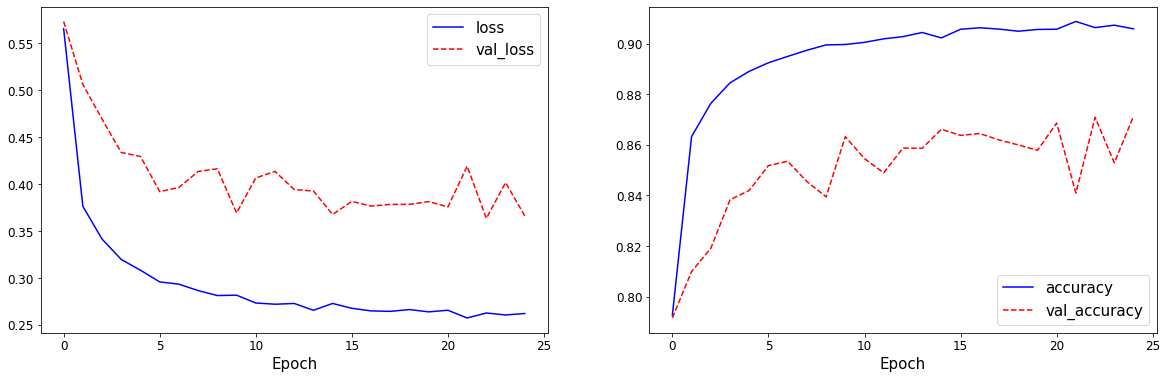

In [11]:
## train data와 test data의 loss와 accuracy 그래프 그리기 : num of Epochs = 30
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 6))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch', size=15)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend(fontsize=15)

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], 'b-', label='accuracy')
plt.plot(history.history['val_accuracy'], 'r--', label='val_accuracy')
plt.xlabel('Epoch', size=15)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend(fontsize=15, loc='lower right')

plt.show()

In [12]:
model.evaluate(test_X, test_Y, verbose=False)

[0.21773943305015564, 0.9203000068664551]

In [31]:
np.random.randint(low=-2, high=3, size=10)

array([ 1, -2, -1, -1, -2,  0, -2,  0,  0,  2])

In [46]:
x = np.arange(8).reshape(-1, 4)
print(x)
print()
np.random.seed(123)
y = np.random.randint(train_X.shape[0], size=10)
z = np.random.randint(low=train_X.shape[0], size=10)
w = np.random.randint(low=train_X.shape[0], high=train_X.shape[0]+100000, size=10)

print(y)
print()
print(z)
print()
print(w)

[[0 1 2 3]
 [4 5 6 7]]

[52734 15725 28030 17730 54370 15377  7763 46203 58937 23766]

[22241    96 55409 23166 53295 53321  5664 33710 55520   111]

[ 77747  95662 128861 156676  74944 143012 133521 105507  86626 132020]
